# **Logistic Regression Notebook**
Author: Nicole McNabb
DATASCI 207 Final Project

# **Data Pre-Processing**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk

from nltk.corpus import stopwords 
STOPWORDS=set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import string
stemmer = nltk.SnowballStemmer("english")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-05 12:22:12.194816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 12:22:12.195036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 12:22:12.397270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/preprocessed-datav1/transformer_preprocessed_data.pkl


In [2]:
df = pd.read_pickle("/kaggle/input/preprocessed-datav1/transformer_preprocessed_data.pkl")

df 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,positive
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,negative
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",neutral
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,positive


In [3]:
# Check for missing Text entries

df['Text'].isnull().sum()

0

In [4]:
# Check for missing scores

df['Score'].isnull().sum()

0

In [5]:
# Keeping only the first of any duplicates

df.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True)

In [6]:
df.shape

(393675, 11)

In [7]:
# Drop all neutrally scored reviews

df = df[df['Sentiment']!='neutral']
df = df[df['Score']!=3]

# Drop all conflicting reviews

df = df[~((df['Score'] >= 4) & (df['Sentiment'] != 'positive'))]
df = df[~((df['Score'] <= 2) & (df['Sentiment'] != 'negative'))]

df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,positive
...,...,...,...,...,...,...,...,...,...,...,...
568447,568448,B001EO7N10,APWCOAVILK94B,"Real Named Person ""wowzee""",0,0,5,1322524800,"If its all natural, this is like panacea of Sp...","Hoping there is no MSG in this, this tastes ex...",positive
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,positive
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,negative
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,positive


In [8]:
# Function to clean up the texts and get the stemmed version of words
# Stemming: Running -> Run, preprocessing -> process

def clean(text):
    text=str(text).lower()
     # Remove text within square brackets
    text=re.sub('\[.*?\]','',text)
    # Remove URLs
    text=re.sub('https?://\S+|www\.\S+','',text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #  Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters with spaces
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
     # Tokenize the text and remove stopwords
    text = [word for word in text.split(' ') if word not in STOPWORDS]
    text=" ".join(text)
    # Stem the remaining words
    text = [stemmer.stem(word) for word in text.split(' ')]
    # Join the cleaned and stemmed words back into a string
    text=" ".join(text)
    return text

df['Text'] = df["Text"].apply(clean)

In [9]:
# Function for grouping scores as positive (1) or negative (0)

def group(score):
    if score > 3:
        return 1
    elif score <= 3:
        return 0

df['Score'] = df['Score'].apply(group)

In [10]:
text = df['Text'].values

text

array(['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better ',
       'product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo',
       'confect around centuri  light pillowi citrus gelatin nut  case filbert cut tini squar liber coat powder sugar  tini mouth heaven  chewi flavor  high recommend yummi treat  familiar stori cs lewi lion witch wardrob  treat seduc edmund sell brother sister witch',
       ...,
       'im disappoint flavor chocol note especi weak milk thicken flavor still disappoint worth tri ill never buy use what left gone time thank small can',
       'best treat train reward dog good groom  lower calori love doggi  sweet potato seem favorit wet nose treat',
       'satisfi product advertis use cereal raw vinegar general sweetner'],
      dtype=object)

In [11]:
# Get vocab size for embedding layers later on

tokens = []

for sentence in text:
    
    tokens.extend(sentence.split())
    
word_count = {}

for token in tokens:
    
    if token in word_count:
    
        word_count[token] += 1
    
    else:
    
        word_count[token] = 1
        
vocab_size = len(word_count)

print("Vocabulary size:", vocab_size)

Vocabulary size: 207654


In [12]:
tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(text)

sequences = tokenizer.texts_to_sequences(text)

In [13]:
padded_sequences = pad_sequences(sequences)
padded_sequences

array([[   0,    0,    0, ...,  796,    8,   38],
       [   0,    0,    0, ..., 2672,    8, 3633],
       [   0,    0,    0, ...,  366, 1457, 1130],
       ...,
       [   0,    0,    0, ...,  184,  133,  215],
       [   0,    0,    0, ...,  946, 1323,   60],
       [   0,    0,    0, ...,  834,  652, 1661]], dtype=int32)

In [14]:
padded_sequences.shape

(325642, 1034)

# **Logistic Regression - Baseline Model**
First, we want to run a baseline logistic regression model without hyper-parameter tuning and n-grams implementation to see the results.

In [22]:
from sklearn.model_selection import train_test_split

# Initially split into training set and other set
X_train, X_valid, y_train, y_valid = train_test_split(padded_sequences, df['Score'], test_size=0.6)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(130256, 1034) (97693, 1034) (97693, 1034)
(130256,) (97693,) (97693,)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Train logistic regression model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

# Evaluate on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Classification Report:\n{train_report}')

# Validate the model
y_valid_pred = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_report = classification_report(y_valid, y_valid_pred)

print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Classification Report:\n{valid_report}')

# Test the model
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Classification Report:\n{test_report}')

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.8698716373909839
Train Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.00      0.01     16902
           1       0.87      1.00      0.93    113354

    accuracy                           0.87    130256
   macro avg       0.61      0.50      0.47    130256
weighted avg       0.80      0.87      0.81    130256

Validation Accuracy: 0.8666537008792851
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.00      0.00     12928
           1       0.87      1.00      0.93     84765

    accuracy                           0.87     97693
   macro avg       0.52      0.50      0.47     97693
weighted avg       0.78      0.87      0.81     97693

Test Accuracy: 0.868813528093108
Test Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.00      0.00     12714
           1       0.87      1.00     

**Training Results:**
The training accuracy of the baseline logistic regression model is 86.99%, reflecting consistent performance with the training data. However, the classification report highlights a significant performance disparity between the classes. The model maintains high precision and recall for class 1, resulting in a strong F1-score of 0.93 and contributing to the overall high weighted average F1-score of 0.81. In contrast, the model performs poorly on class 0, with a precision of 0.35 and a recall near 0, suggesting it fails to correctly identify the minority class in the training data. These results emphasize the need for techniques to address class imbalance to enhance the model's ability to predict the minority class accurately.

**Validation Results:**
The validation accuracy of the logistic regression model is 86.91%, showing consistent performance with the training data. However, the classification report again highlights significant performance disparity between the classes. The model maintains high precision and recall for class 1, resulting in a strong f1-score of 0.93 and contributing to the overall high weighted average f1-score of 0.81. In contrast, the model performs poorly on class 0, with a precision of 0.09 and a recall near 0, suggesting it fails to correctly identify the minority class in the validation data. These results emphasize the need for techniques to address class imbalance to enhance the model's ability to predict the minority class accurately.

**Test Results:**
The test accuracy of the logistic regression model is 86.96%, consistent with the training and validation phases. The classification report again shows a high performance for class 1 (the majority class), with a precision and recall of 0.87 and 1.00, respectively, leading to a strong f1-score of 0.93. However, the model struggles significantly with class 0 (the minority class), achieving a precision of 0.13 and a recall close to 0, resulting in an f1-score of 0.00. The macro average f1-score of 0.47 and the weighted average f1-score of 0.81 reflect this imbalance, indicating the model's difficulty in correctly identifying instances of the minority class. These results suggest a persistent issue with class imbalance, necessitating techniques like class weighting or resampling to improve the model's performance on the minority class. 

**Final Takeaways from the Baseline Model:**
The training, validation and test accuracies are slow. It is clear that there were no hyper-parameter tuning techniques implemented into the baseline based on the classification reports. Next, n-gram and SMOTE will be implemented to our dataset to ensure the highest logistic regression model results.

# **Logistic Regression - N-Gram & SMOTE Implementation**
In this model implementation, n-grams and SMOTE used to enhance the performance of the logistic regression classifier on the sentiment analysis task. N-grams (unigrams and bigrams) capture both individual word frequencies and simple word combinations, enriching the text representation and helping the model better understand context and dependencies between words. SMOTE addresses class imbalance by generating synthetic samples for the minority class, ensuring the model is trained on a balanced dataset. This combination allows the model to leverage richer textual information and effectively handle class imbalance, leading to more accurate and robust sentiment predictions.

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform

# TF-IDF Vectorizer with n-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', solver='liblinear')

Now that n-grams and SMOTE have been applied to the data, we can explore hyper-parameter tuning. Two techniques were used for hyper-parameter tuning in our logistic regresison model: a) Random Search and b) Bayesian Optimization.

# **Logistic Regression - Random Search**
First, we will try Random Search.

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l1', 'l2']
}

# Randomized search 
random_search = RandomizedSearchCV(
    log_reg, param_distributions, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train_res, y_train_res)

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluation on training data
y_train_pred = best_model.predict(X_train_res)
train_accuracy = accuracy_score(y_train_res, y_train_pred)
train_report = classification_report(y_train_res, y_train_pred)

# Evaluation on test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Training Accuracy:", train_accuracy)
print(f"Training Classification Report:\n, {train_report}")
print("Test Accuracy:", accuracy)
print(f"Test Classification Report:\n, {test_report}")

Best Parameters: {'C': 69.58780103230364, 'penalty': 'l1'}
Training Accuracy: 0.9765453903214412
Training Classification Report:
,               precision    recall  f1-score   support

    negative       0.97      0.98      0.98    226480
    positive       0.98      0.97      0.98    226480

    accuracy                           0.98    452960
   macro avg       0.98      0.98      0.98    452960
weighted avg       0.98      0.98      0.98    452960

Test Accuracy: 0.9481951204532543
Test Classification Report:
,               precision    recall  f1-score   support

    negative       0.76      0.89      0.82      8511
    positive       0.98      0.96      0.97     56618

    accuracy                           0.95     65129
   macro avg       0.87      0.92      0.89     65129
weighted avg       0.95      0.95      0.95     65129



**Random Search Results:**
As seen above, random search dramatically increased the training and test accuracy. The random search optimization for the logistic regression model yielded the best parameters with a regularization strength 𝐶 of approximately 69.59 and an L1 penalty. The model achieved a high training accuracy of 97.65%, with a well-balanced performance across both negative and positive sentiment classes, as indicated by the precision, recall, and F1-scores all around 0.98. On the test set, the model maintained a strong accuracy of 94.82%. The positive sentiment class showed excellent precision and recall (0.98 and 0.96, respectively), while the negative sentiment class had lower precision and recall (0.76 and 0.89, respectively). This indicates that while the model generalizes well to new data, it performs better at identifying positive sentiments. The use of the L1 penalty also contributed to a more interpretable model by encouraging sparsity in the feature set. Overall, the model demonstrates robust performance, though there is room for improvement in handling the negative sentiment class.

# **Logistic Regression - Bayesian Optimization**
Next, we will see how Bayesian Optimization works on the logistic regression model.

In [19]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# TF-IDF Vectorizer with n-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Logistic Regression 
log_reg = LogisticRegression(class_weight='balanced', solver='liblinear')

# Define the parameter space for Bayesian optimization
param_space = {
    'C': Real(1e-4, 1e2, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2'])
}

# Bayesian search
bayes_search = BayesSearchCV(
    log_reg, param_space, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Fit the Bayesian search model
bayes_search.fit(X_train_res, y_train_res)

# Best parameters and model
best_params = bayes_search.best_params_
best_model = bayes_search.best_estimator_

# Evaluation on training data
y_train_pred = best_model.predict(X_train_res)
train_accuracy = accuracy_score(y_train_res, y_train_pred)
train_report = classification_report(y_train_res, y_train_pred)

# Evaluation on test data
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Best Parameters:", best_params)
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Classification Report:\n{train_report}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Classification Report:\n{test_report}")

Best Parameters: OrderedDict([('C', 54.05898881406361), ('penalty', 'l2')])
Training Accuracy: 0.975547509713882
Training Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.98      0.98    226480
    positive       0.98      0.97      0.98    226480

    accuracy                           0.98    452960
   macro avg       0.98      0.98      0.98    452960
weighted avg       0.98      0.98      0.98    452960

Test Accuracy: 0.9491470773388199
Test Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.90      0.82      8511
    positive       0.98      0.96      0.97     56618

    accuracy                           0.95     65129
   macro avg       0.87      0.93      0.90     65129
weighted avg       0.95      0.95      0.95     65129



**Bayesian Optimization:**
The Bayesian optimization for the logistic regression model identified the best parameters with a regularization strength 𝐶 of approximately 54.06 and an L2 penalty. The model achieved a high training accuracy of 97.55%, with both negative and positive sentiment classes exhibiting strong precision, recall, and F1-scores around 0.98. On the test set, the model maintained an accuracy of 94.91%, with the positive sentiment class showing excellent precision (0.98) and recall (0.96). The negative sentiment class had a precision of 0.76 and a recall of 0.90, resulting in an F1-score of 0.82. The L2 penalty helped to prevent overfitting by maintaining all features while regularizing their weights. Overall, the model demonstrates robust performance, especially in identifying positive sentiments, with room for improvement in better capturing negative sentiments.

# **Bayesian Optimization - Logistic Regression Visualizations**

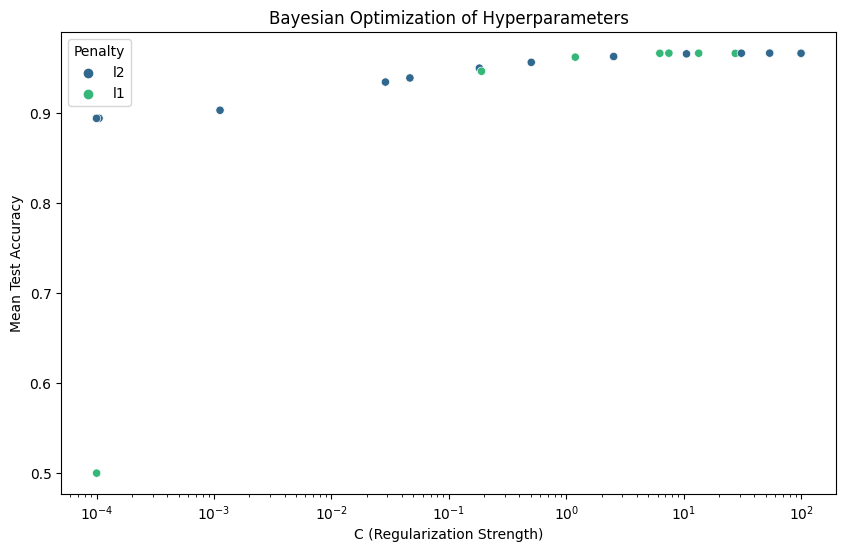

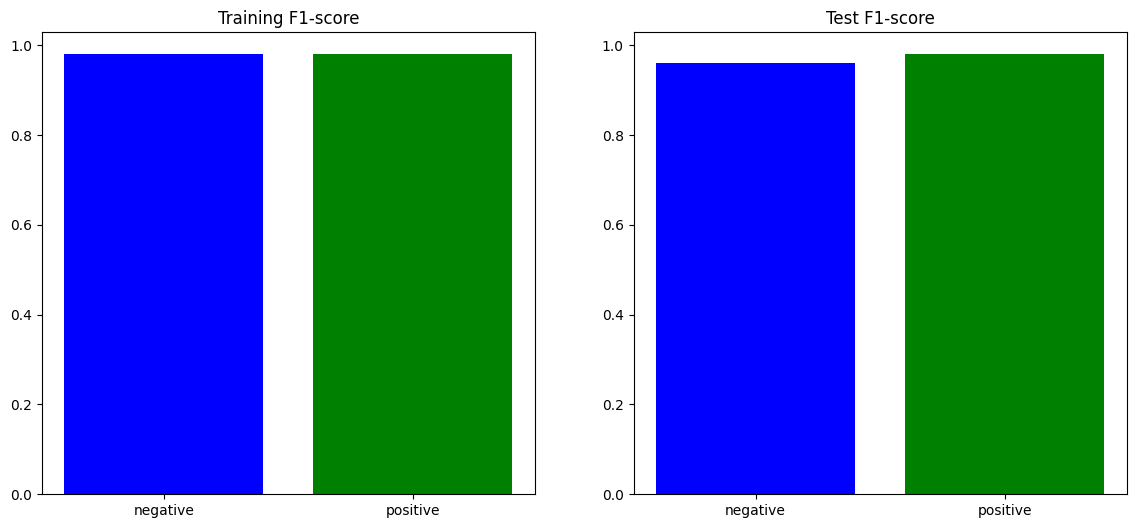

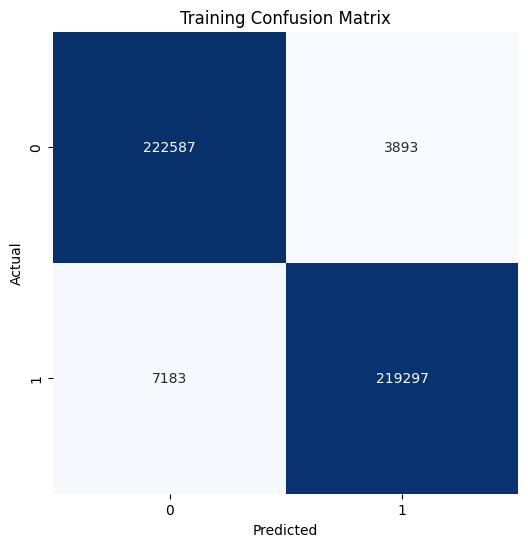

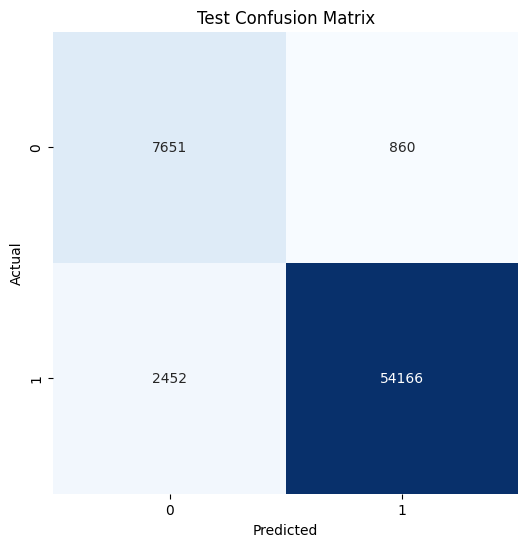

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Hyperparameter Optimization Plot
results = pd.DataFrame(bayes_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='param_C', y='mean_test_score', hue='param_penalty', data=results, palette='viridis')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Bayesian Optimization of Hyperparameters')
plt.legend(title='Penalty')
plt.show()

# Performance Metrics
metrics = ['precision', 'recall', 'f1-score']
classes = ['negative', 'positive']
scores_train = [0.97, 0.98, 0.98, 0.98, 0.97, 0.98] 
scores_test = [0.76, 0.98, 0.82, 0.90, 0.96, 0.97] 

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i, metric in enumerate(metrics):
    ax[0].bar(classes, scores_train[i*2:i*2+2], color=['blue', 'green'])
    ax[0].set_title(f'Training {metric.capitalize()}')
    ax[1].bar(classes, scores_test[i*2:i*2+2], color=['blue', 'green'])
    ax[1].set_title(f'Test {metric.capitalize()}')

plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train_res, best_model.predict(X_train_res), 'Training Confusion Matrix')
plot_confusion_matrix(y_test, best_model.predict(X_test), 'Test Confusion Matrix')

**Final Conclusions:**
These results suggest that while the model generalizes well to new data, it is particularly effective at identifying positive sentiments. The use of Bayesian optimization helped to fine-tune the hyperparameters effectively, resulting in a model with high accuracy and balanced performance across sentiment classes, with a slight edge in identifying positive sentiments.